Loading Mnist Data

In [5]:
from datasets import load_dataset

#load data (image)
mnist = load_dataset("mnist")

print(mnist)
print(mnist['train'][0])
print(mnist['test'][0])

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})
{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x105AFEB50>, 'label': 5}
{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x120929010>, 'label': 7}


Train, Validation, Test Split

In [6]:
from datasets import DatasetDict, concatenate_datasets

combined_data = concatenate_datasets([mnist["train"], mnist["test"]])
train_val_data = combined_data.train_test_split(test_size=0.2, seed=42)
val_test_data = train_val_data["test"].train_test_split(test_size=0.5, seed=42)
#train_val_test 8:1:1

mnist_split = DatasetDict({
    "train": train_val_data["train"],
    "val": val_test_data["train"],
    "test": val_test_data["test"]
})

print(mnist_split)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 56000
    })
    val: Dataset({
        features: ['image', 'label'],
        num_rows: 7000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 7000
    })
})


Parsing Mnist (IMAGE -> ARRAY)

In [15]:
import numpy as np

def parsing_data(data):
    
    images = np.array([np.array(row['image'], dtype=np.float32).flatten() for row in data])
    labels = np.array([row['label'] for row in data], dtype=np.int32)
    return images, labels
#flatten image into 764 dim numpy array

train_data, train_labels = parsing_data(mnist_split['train'])
val_data, val_labels=parsing_data(mnist_split['val'])
test_data , test_labels= parsing_data(mnist_split['test'])

In [16]:
print("Befor Parsing")
print(f"mnist train data shape : {mnist_split['train'][0]['image']}")
print(f"mnist test data shape : {mnist_split['test'][0]['image']}")


print("-"*500)
print("After Parsing:")
print(f"train data shape: {train_data.shape}")
print(f"test data shape: {test_data.shape}")

Befor Parsing
mnist train data shape : <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x140A4E190>
mnist test data shape : <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x1208A2190>
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
After Parsing:
train data shape: (56000, 784)
test data shape: (7000, 784)


Normalization

In [18]:
def compute_mean_std(data):

    mean = data.mean(axis=0)  
    std = data.std(axis=0)
    
    std[std ==0] = 1
    return mean, std

def preprocess_mnist(data, mean, std):
    
    normalized_data = (data - mean) / std
    return normalized_data


mean, std = compute_mean_std(train_data) 
train_mnist_per_dim = preprocess_mnist(train_data, mean, std)
val_mnist_per_dim = preprocess_mnist(val_data, mean, std)
test_mnist_per_dim = preprocess_mnist(test_data, mean, std)


print("Training data shape:", train_mnist_per_dim.shape) 
print("Validation data shape:", val_mnist_per_dim.shape) 
print("Test data shape:", test_mnist_per_dim.shape)      


Training data shape: (56000, 784)
Validation data shape: (7000, 784)
Test data shape: (7000, 784)


In [19]:
print("Normalized training mean :", train_mnist_per_dim.mean(axis=0)[:100])
print("Normalized training std :", train_mnist_per_dim.std(axis=0)[:100])

Normalized training mean : [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.85013442e-07  4.07268089e-07 -7.19468687e-07 -7.19468801e-07
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.34933792e-07  1.01950285e-07  7.47477543e-07 -3.23260991e-07
 -8.20627690e-07  3.83085393e-07  1.90111535e-07 -6.82606242e-07
 -1.18714343e-06 -2.09542193e-07  1.02454464e-06 -6.18442115e-08
  4.30400377e-07  1.41061071e-06  1.02903492e-07  3.84873204e-07
 -6.57643170e-07 -1.78996038e-06 -1.94609311e-06  9.93532808e-07
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -7.36987431e-07  2.48862531e-0

Compute pairwise similarities

Euclidian distance

In [9]:
from tqdm import tqdm

def euc_distance(x, y):
    return np.sqrt(np.sum((x[:, np.newaxis, :] - y[np.newaxis, :, :])**2, axis=-1))

# use broadcasting to calcualte the euclidean distance

def batch_euclidean_dist(train_data, other_data, batch_size=100):
    n_train = train_data.shape[0]
    n_other = other_data.shape[0]
    
    distance_matrix = np.zeros((n_train, n_other)) 

    for i in tqdm(range(0, n_train, batch_size)):
        for j in range(0, n_other, batch_size):
            batch_train = train_data[i:i + batch_size]
            batch_other = other_data[j:j + batch_size]
            
            distances = euc_distance(batch_train, batch_other)
            distance_matrix[i:i + batch_size, j:j + batch_size] = distances
    
    return distance_matrix


train_val_dis = batch_euclidean_dist(train_mnist_per_dim, val_mnist_per_dim, batch_size=100)
train_test_dis = batch_euclidean_dist(train_mnist_per_dim, test_mnist_per_dim, batch_size=100)

print("Train-Validation Distance Matrix Shape:", train_val_dis.shape)
print("Train-Test Distance Matrix Shape:", train_test_dis.shape)

100%|██████████| 560/560 [04:15<00:00,  2.19it/s]

Train-Validation Distance Matrix Shape: (56000, 7000)
Train-Test Distance Matrix Shape: (56000, 7000)


Cosine similarity

In [20]:
from tqdm import tqdm
import numpy as np

def cosine_similarity(x, y):
    
    #calculate norm
    norm_x = np.linalg.norm(x, axis=-1, keepdims=True) 
    norm_y = np.linalg.norm(y, axis=-1, keepdims=True) 

    #dot product
    dot_product = np.dot(x, y.T)  

    cosine_sim = dot_product / (norm_x * norm_y.T + 1e-8)  
    return cosine_sim

def batch_cosine_similarity(train_data, other_data, batch_size=100):

    n_train = train_data.shape[0]
    n_other = other_data.shape[0]
    
    sim_matrix = np.zeros((n_train, n_other))  

    for i in tqdm(range(0, n_train, batch_size), desc="Processing Train Batches"):
        for j in range(0, n_other, batch_size):
            batch_train = train_data[i:i + batch_size]
            batch_other = other_data[j:j + batch_size]
            
            similarities = cosine_similarity(batch_train, batch_other)
            sim_matrix[i:i + batch_size, j:j + batch_size] = similarities
    
    return sim_matrix


train_val_similarities = batch_cosine_similarity(train_mnist_per_dim, val_mnist_per_dim, batch_size=100)
train_test_similarities = batch_cosine_similarity(train_mnist_per_dim, test_mnist_per_dim, batch_size=100)

print("Train-Validation Similarity Matrix Shape:", train_val_similarities.shape)
print("Train-Test Similarity Matrix Shape:", train_test_similarities.shape)

Processing Train Batches: 100%|██████████| 560/560 [23:39<00:00,  2.54s/it]

Train-Validation Similarity Matrix Shape: (56000, 7000)
Train-Test Similarity Matrix Shape: (56000, 7000)


In [27]:
print(train_val_similarities[1,:10])
print(train_test_similarities[1,:10])

[-0.07934432  0.13941577  0.11721499 -0.04407447 -0.0729043  -0.09397285
  0.10100984 -0.09694926 -0.10693745 -0.13937376]
[ 0.32427254  0.02712312  0.06362518  0.02077145 -0.00523477 -0.0007168
  0.61245728 -0.16418684 -0.16170903 -0.01507664]


In [10]:
def knn_predict(train_labels, distance_matrix, k):
    n_queries = distance_matrix.shape[1]  
    predictions = []

    for i in tqdm(range(n_queries)):
        
        #get indices of k neighbors
        k_nearest_indices = np.argsort(distance_matrix[:, i])[:k]
        k_nearest_labels = train_labels[k_nearest_indices]
        
        #majority voting
        unique_labels, counts = np.unique(k_nearest_labels, return_counts=True)
        predicted_label = unique_labels[np.argmax(counts)]
        
        predictions.append(predicted_label)
    
    return np.array(predictions)

def find_best_k(train_labels, val_labels, train_val_distances, k_values):
    best_k = None
    best_accuracy = 0

    for k in k_values:
        val_predictions = knn_predict(train_labels, train_val_distances, k)
        
        accuracy = np.mean(val_predictions == val_labels)
        print(f"k={k}, Validation Accuracy={accuracy:.4f}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_k = k
    
    return best_k, best_accuracy

def compute_test_accuracy(train_labels, test_labels, train_test_distances, best_k):
    test_predictions = knn_predict(train_labels, train_test_distances, best_k)
    accuracy = np.mean(test_predictions == test_labels)
    return accuracy

k_values = [1, 3, 5, 7, 9]  
best_k, best_val_accuracy = find_best_k(train_labels, val_labels, train_val_dis, k_values)
print(f"Best k: {best_k}, Best Validation Accuracy: {best_val_accuracy:.4f}")

test_accuracy = compute_test_accuracy(train_labels, test_labels, train_test_dis, best_k)
print(f"Test Accuracy with k={best_k}: {test_accuracy:.4f}")

100%|██████████| 7000/7000 [00:42<00:00, 162.90it/s]


k=1, Validation Accuracy=0.9516


100%|██████████| 7000/7000 [00:33<00:00, 208.55it/s]


k=3, Validation Accuracy=0.9513


100%|██████████| 7000/7000 [00:32<00:00, 213.35it/s]


k=5, Validation Accuracy=0.9517


100%|██████████| 7000/7000 [00:34<00:00, 201.35it/s]


k=7, Validation Accuracy=0.9511


100%|██████████| 7000/7000 [00:33<00:00, 211.48it/s]


k=9, Validation Accuracy=0.9486
Best k: 5, Best Validation Accuracy: 0.9517


100%|██████████| 7000/7000 [00:44<00:00, 156.59it/s]

Test Accuracy with k=5: 0.9449


100%|██████████| 7000/7000 [00:33<00:00, 208.61it/s]

Number of misclassified images: 10


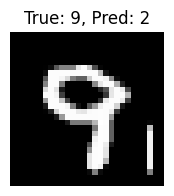

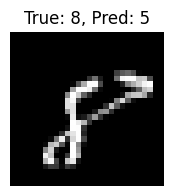

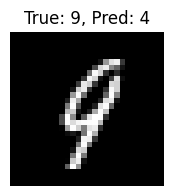

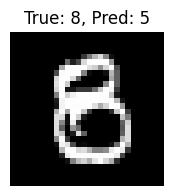

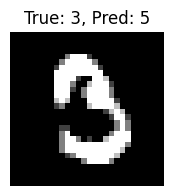

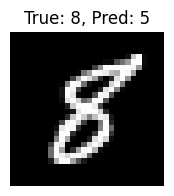

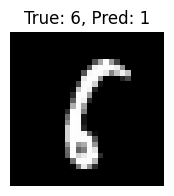

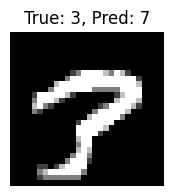

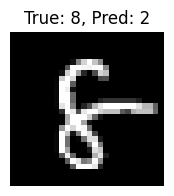

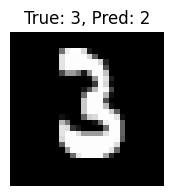

In [13]:
def show_misclassified_images(train_labels, test_labels, train_test_distances, best_k, test_data):
    
    test_images = np.array(test_data["image"])
    test_labels = np.array(test_data["label"])
    
    test_predictions = knn_predict(train_labels, train_test_distances, best_k)
    
    # where mis-predicted indices
    misclassified_indices = np.where(test_predictions != test_labels)[0]
    
    misclassified_indices = misclassified_indices[:10]
    
    print(f"Number of misclassified images: {len(misclassified_indices)}")
    
    for i, idx in enumerate(misclassified_indices):
        plt.figure(figsize=(2, 2))
        plt.imshow(test_images[int(idx)], cmap='gray')  
        plt.title(f"True: {test_labels[int(idx)]}, Pred: {test_predictions[int(idx)]}")
        plt.axis('off')
        plt.show()

show_misclassified_images(train_labels, test_labels, train_test_dis, best_k, mnist_split['test'])